In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from TSB_AD.snn.spikingjelly.encoders import DynamicReceptiveEncoder, RepeatEncoder, ReceptiveEncoder

In [48]:
seed = 2002
torch.manual_seed(seed)
np.random.seed(seed)

In [49]:
type = 'multi'
single = False
normalize = 'z-score' # 'z-score', '0-1', None

if type == 'multi':
    #file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/001_Genesis_id_1_Sensor_tr_4055_1st_15538.csv', 4, 1000, 20650)
    file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/018_Daphnet_id_1_HumanActivity_tr_9693_1st_20732.csv', 4, 100, 20650)
    #file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/115_PSM_id_1_Facility_tr_50000_1st_129872.csv', 4, 1000, 20650)
    #file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/137_CreditCard_id_1_Finance_tr_500_1st_541.csv', 4, 100, 500)
    #file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/173_GECCO_id_1_Sensor_tr_16165_1st_16265.csv', 4, 1000, 15765)
    
    #file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/032_GHL_id_1_Sensor_tr_50000_1st_65001.csv', -6, 5000, 64991)
    #file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/042_GHL_id_11_Sensor_tr_50000_1st_150001.csv', 9, 5000, 148001)
    #file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/065_SMD_id_9_Facility_tr_737_1st_837.csv', 0, 500, 700)
    #file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/019_MITDB_id_1_Medical_tr_37500_1st_103211.csv', 0, 1000, 103181)
    #file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/130_OPPORTUNITY_id_2_HumanActivity_tr_1045_1st_1145.csv', 27, 2000, 800)
    #file_path, target_channel, window_size, idx_start = ('/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/116_TAO_id_1_Environment_tr_500_1st_3.csv', 4, 50, 0)
    
    idx_end = idx_start + window_size
    if single:
        df = pd.read_csv(file_path)
        data = df.iloc[idx_start:idx_end, target_channel]
        label = df.iloc[idx_start:idx_end, -1].values
        if normalize == 'z-score':
            data = (data - data.mean()) / (data.std() + 1e-8)
        elif normalize == '0-1':
            data = (data - data.min()) / (data.max() - data.min())
        data = data.values.reshape(-1, 1)
        original_data = df.iloc[:, target_channel].values.reshape(-1, 1)
        original_label = df.iloc[:, -1].values
    else: 
        df = pd.read_csv(file_path)
        data = df.iloc[idx_start:idx_end, :-1]
        label = df.iloc[idx_start:idx_end, -1].values
        if normalize == 'z-score':
            data = (data - data.mean()) / (data.std() + 1e-8)
        elif normalize == '0-1':
            data = (data - data.min()) / (data.max() - data.min())
        data = data.values
        original_data = df.iloc[:, :-1].values
        original_label = df.iloc[:, -1].values

In [50]:
print(data.shape, label.shape)

(100, 9) (100,)


In [51]:
tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

In [52]:
print(tensor.shape) # B, L, C

torch.Size([1, 100, 9])


In [53]:
from TSB_AD.snn.params import running_params
running_params['model']['window_size'] = window_size
for k, v in running_params.items():
    print(f'{k}: {v}')

num_enc_features = 8

'''encoder = DynamicReceptiveEncoder(
    local_running_params=running_params,
    num_raw_features=1,
    num_enc_features=num_enc_features,
)'''

#encoder = RepeatEncoder(local_running_params=running_params, output_size=num_enc_features)

running_params['ParallelSNNModel']['delta_abs'] = True
encoder = ReceptiveEncoder(
    local_running_params=running_params,
    num_raw_features=data.shape[1],  # Number of features in the input data
    num_enc_features=num_enc_features,
)

data: {'dataset_dir': '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M', 'file_list': '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/File_List/TSB-AD-M-Tiny-Eva.csv', 'score_dir': '/home/hwkang/dev-TSB-AD/TSB-AD/scores', 'result_dir': '/home/hwkang/dev-TSB-AD/TSB-AD/results/tiny', 'swap': False, 'shuffle': False, 'normalize': False, 'drop': False}
meta: {'root_dir_path': '/home/hwkang/dev-TSB-AD/TSB-AD/', 'AD_Name': None, 'Encoder_Name': None, 'postfix': None, 'id_code': 0, 'base_file_name': None}
analysis: {'wandb': False, 'spikerate': False, 'spike': False}
model: {'device_type': 'cuda', 'batch_size': 128, 'max_epochs': 1000, 'validation_size': 0.2, 'window_size': 100, 'predict_time_steps': 1}
ParallelSNNModel: {'num_enc_features': 32, 'norm_type': 'ln', 'dropout': False, 'neuron_type': 'spikingjelly', 'step_mode': 'm', 'encoding_kernel': [3, 5, 7], 'tt': False, 'delta_abs': True, 'grad_spike': False, 'parallel': False}


In [54]:
encoding, act, dact = encoder(tensor, vizualize=True)
print(encoding.shape)  # B, L, C

tensor([0., 0., 0., 1., 1., 0., 0., 0., 0.])
torch.Size([1, 1, 8, 100])


In [55]:
B, _, E, L = encoding.shape
viz_encoding = encoding.view(L, -1).detach().numpy()
viz_act = act.view(L, -1).detach().numpy()
viz_dact = dact.view(L, -1).detach().numpy()
print(viz_encoding.shape)  # L, B * E
print(viz_act.shape)  # L, B * E
print(viz_dact.shape)  # L, B * E

(100, 8)
(100, 8)
(100, 8)


In [56]:
def plot_encoding(data, label, encoding, act=None, dact=None):
    num_features = data.shape[1]
    num_enc_features = encoding.shape[1]
    height = (num_features * 2) if num_features > num_enc_features else (num_enc_features * 2)
    
    if num_features > 1:
        fig, axes = plt.subplots(num_features if num_features >= num_enc_features else num_enc_features, 2, figsize=(16, height), sharex=True)
        for i in range(num_features):
            axes[i, 0].plot(data[:, i], label=f'Feature {i + 1}', color='blue')
            axes[i, 0].set_title(f'Original Feature {i + 1}')
            axes[i, 0].set_ylabel('Value')
            for t in range(len(label)):
                if label[t] == 1:
                    axes[i, 0].axvspan(t - 0.5, t + 0.5, color='red', alpha=0.2)
        for j in range(num_enc_features):
            axes[j, 1].plot(encoding[:, j], color='orange', label=f'Encoding Feature {j + 1}')
            axes[j, 1].set_title(f'Encoding Feature {j + 1}')
            axes[j, 1].set_ylabel('Value')
            if act is not None:
                axes[j, 1].plot(act[:, j], color='green', linestyle='--', label='Activation', alpha=0.2)
            if dact is not None:
                axes[j, 1].plot(dact[:, j], color='purple', linestyle='--', label='Delta Activation', alpha=0.2)
            for t in range(len(label)):
                if label[t] == 1:
                    axes[j, 1].axvspan(t - 0.5, t + 0.5, color='red', alpha=0.2)
            #axes[j, 1].legend()
    else:
        fig, axes = plt.subplots(num_features + num_enc_features, 1, figsize=(16, num_enc_features * 2 + 4), sharex=True)
        axes[0].plot(data, color='blue')
        axes[0].set_title('Original Data')
        axes[0].set_ylabel('Value')
        for t in range(len(label)):
            if label[t] == 1:
                axes[0].axvspan(t - 0.5, t + 0.5, color='red', alpha=0.2)

        for i in range(num_enc_features):
            axes[i + 1].plot(encoding[:, i], color='orange')
            axes[i + 1].set_title(f'Encoding Feature {i + 1}')
            axes[i + 1].set_ylabel('Value')
            if act is not None:
                axes[i + 1].plot(act[:, i], color='green', linestyle='--', label='Activation')
            if dact is not None:
                axes[i + 1].plot(dact[:, i], color='purple', linestyle='--', label='Delta Activation')

    plt.xlabel('Time Index')
    # set x-ticks with `idx_start` to `idx_end`
    plt.xticks(ticks=np.arange(0, len(data), 10), labels=np.arange(idx_start, idx_end, 10), rotation=45 if len(data) > 200 else None)
    plt.tight_layout()
    plt.show()

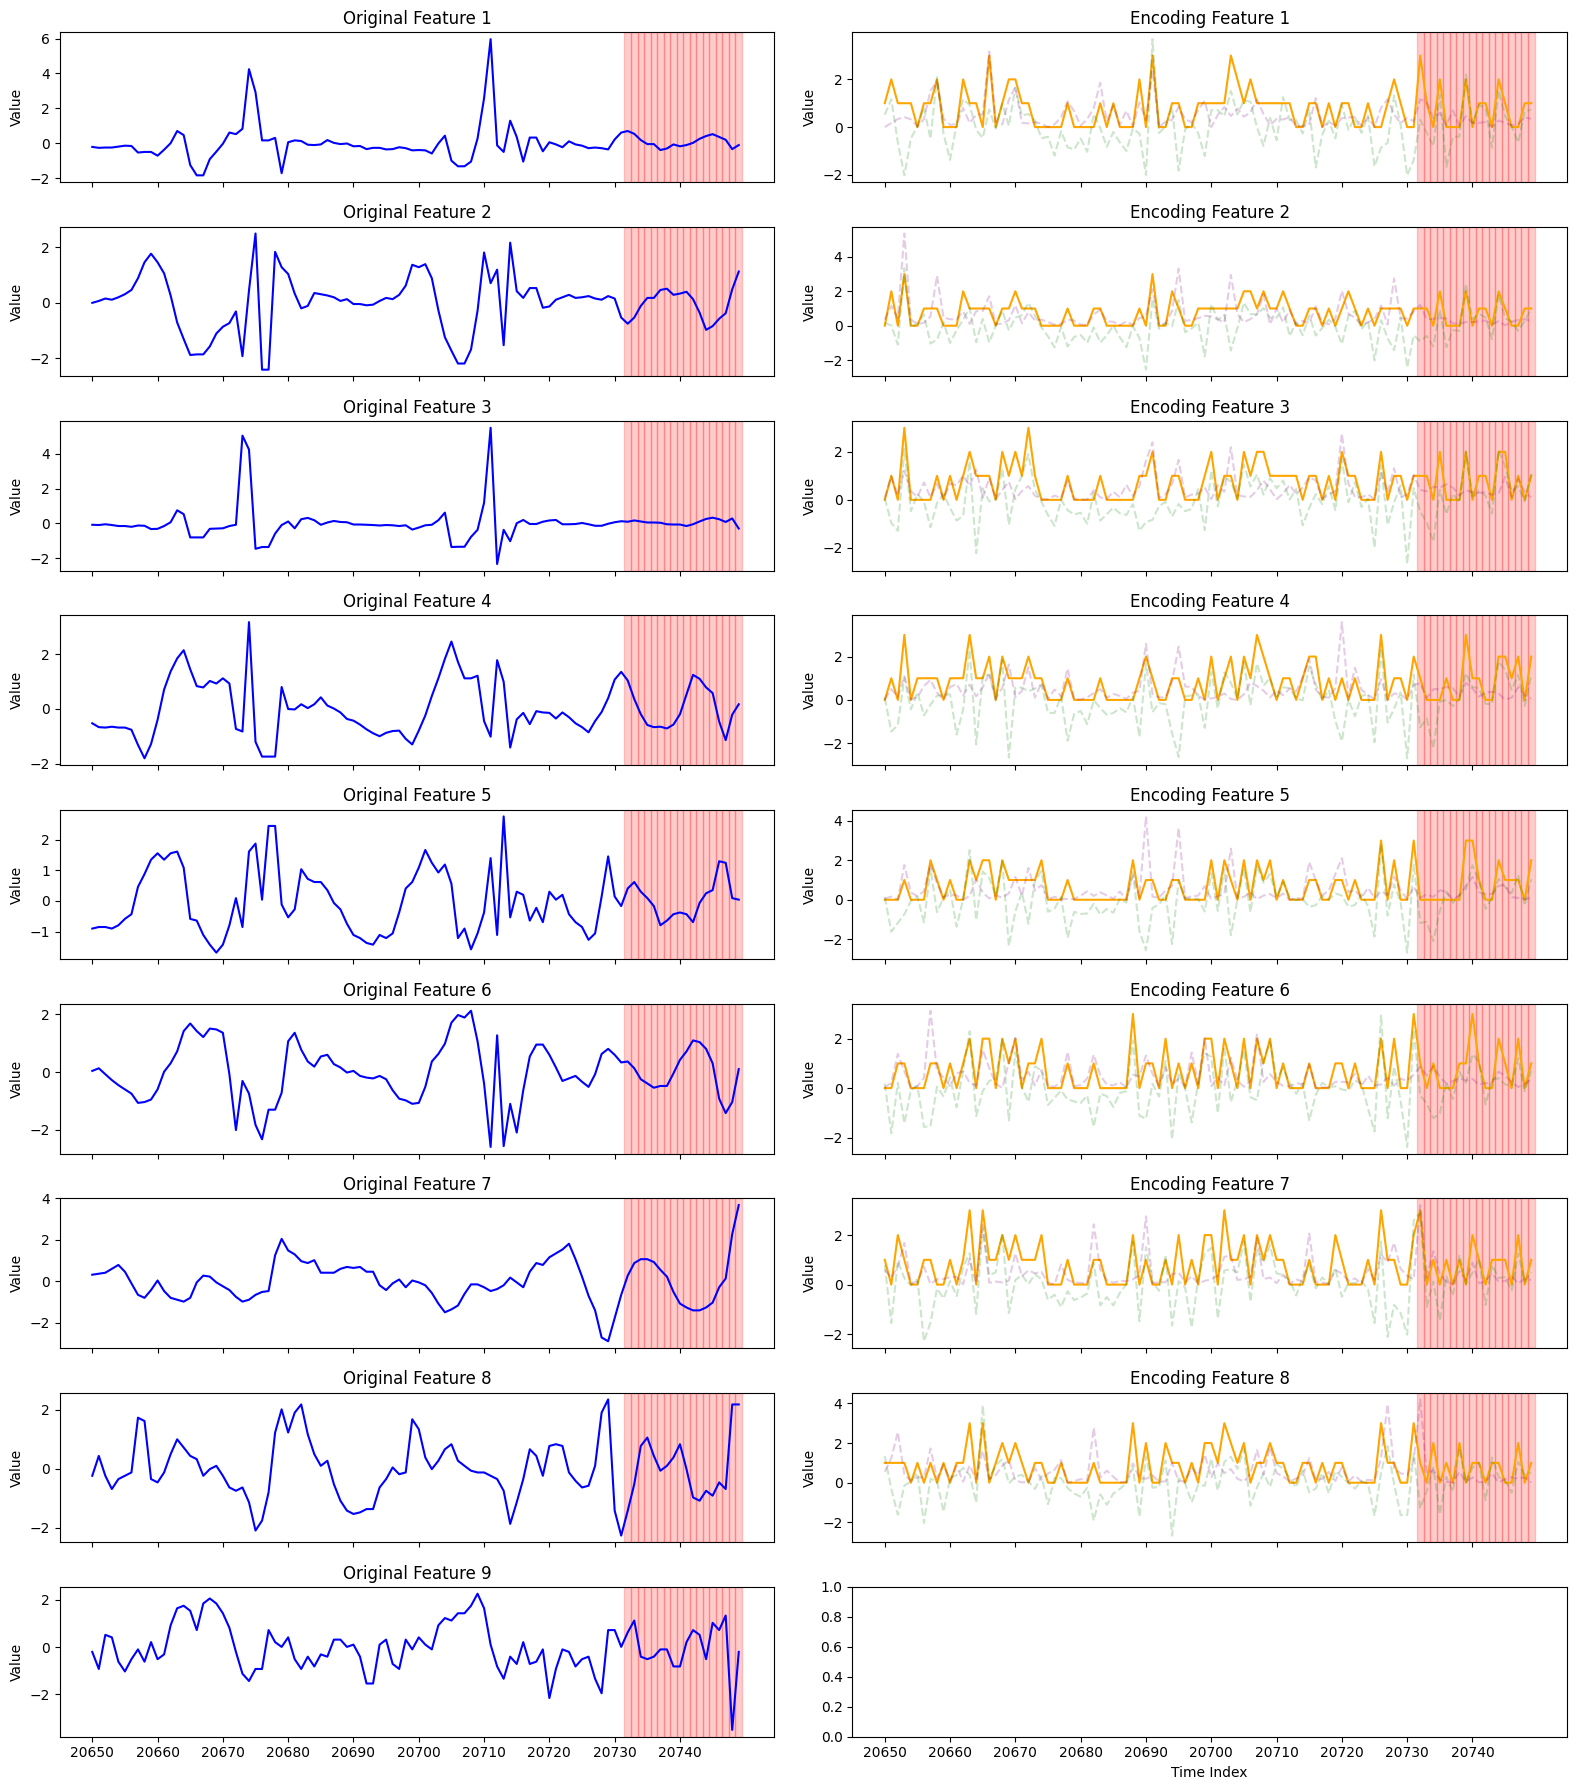

In [57]:
plot_encoding(data, label, viz_encoding, viz_act, viz_dact)